<a href="https://colab.research.google.com/github/CodingYodha/Customer-Review-Sentiment-using-LSTM-/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/CodingYodha/Customer-Review-Sentiment-using-LSTM-.git

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Customer-Review-Sentiment-using-LSTM-/1429_1.csv')

In [ ]:
df.info()

In [ ]:
for col in df.columns:
  print('\n')
  print('='*75)
  print(col)
  print('='*75)
  print(df[col].value_counts())
  print('='*75)
  print('\n')

In [ ]:
df.columns

In [ ]:
columns = ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.id',
       'reviews.numHelpful', 'reviews.sourceURLs',
       'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username']

dfn = df.drop(columns = columns)
dfn.head(3)

In [ ]:
dfn.info()

In [ ]:
dfn.dropna(inplace=True)

In [ ]:
dfn.info()

In [ ]:
!pip install contractions emoji

In [ ]:
!pip install contractions

In [ ]:
import re
import string
import numpy as np
import contractions
import emoji
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob  # Still using TextBlob for sentiment scores
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


class TextPreprocessor:
    def __init__(self, remove_stopwords=True, use_lemmatization=True):
        # Load spaCy English model
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.remove_stopwords = remove_stopwords
        self.use_lemmatization = use_lemmatization

        # Custom stopwords
        self.custom_stopwords = {'movie', 'film', 'show', 'watch', 'seen'}
        self.stop_words = self.nlp.Defaults.stop_words.union(self.custom_stopwords)

    def clean_text(self, text):
        """Basic text cleaning before spaCy processing"""
        if not isinstance(text, str):
            text = str(text)

        # Expand contractions
        text = contractions.fix(text)

        # Convert emojis to text
        text = emoji.demojize(text)

        # Remove URLs and HTML tags
        text = re.sub(r'http\S+|www\S+|https\S+|<.*?>', '', text)

        return text

    def handle_negation(self, doc):
        """Handle negation using spaCy tokens"""
        negation_tokens = {'not', 'no', 'never', 'none', "n't", 'neither', 'nor'}
        negated = []
        negate = False

        for token in doc:
            if token.lower_ in negation_tokens:
                negate = True
            elif token.is_punct:
                negate = False
            elif negate:
                negated.append(f'NOT_{token.lemma_}')
            else:
                negated.append(token.lemma_)
        return negated

    def preprocess(self, text):
        """Complete spaCy-based preprocessing pipeline"""
        try:
            # Clean text first
            text = self.clean_text(text)

            # Process with spaCy
            doc = self.nlp(text)

            # Handle negation and lemmatize
            tokens = self.handle_negation(doc)

            # Filter stopwords and punctuation
            if self.remove_stopwords:
                tokens = [
                    token for token in tokens
                    if (token.lower() not in self.stop_words) and
                       (not self.nlp.vocab[token].is_punct)
                ]

            return tokens

        except Exception as e:
            print(f"Error preprocessing text: {str(e)}")
            return []

class FeatureExtractor:
    def __init__(self, max_features=5000, ngram_range=(1, 3)):
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.95
        )

    def fit_transform(self, texts):
        processed_texts = [' '.join(tokens) for tokens in texts]
        return self.vectorizer.fit_transform(processed_texts)

    def transform(self, texts):
        processed_texts = [' '.join(tokens) for tokens in texts]
        return self.vectorizer.transform(processed_texts)

def prepare_lstm_data(df):
    # Initialize preprocessor
    preprocessor = TextPreprocessor(remove_stopwords=True, use_lemmatization=True)

    # Preprocess texts
    print("Preprocessing texts...")
    df['processed_text'] = df['reviews.text'].apply(preprocessor.preprocess)

    # Convert tokens to strings
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))

    # Convert ratings to labels (example: 1-5 stars to binary sentiment)
    # Modify this based on your rating scale
    df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x > 3 else 0)

    return df



In [ ]:
dfn = prepare_lstm_data(dfn)

In [ ]:
x = dfn['processed_text']
y = dfn['sentiment']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000 , oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

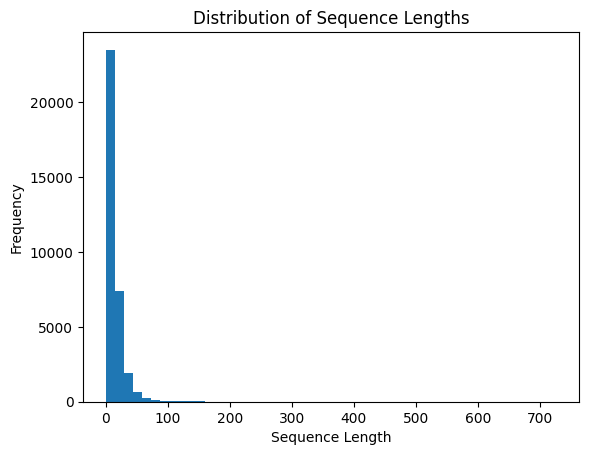

In [78]:
sequence_lengths = [len(seq.split()) for seq in dfn['processed_text']]

import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()


In [79]:
import numpy as np
sequence_lengths = [len(seq.split()) for seq in dfn['processed_text']]
max_length = int(np.percentile(sequence_lengths, 90))
print("90th Percentile Length:", max_length)


90th Percentile Length: 28


In [80]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

In [81]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

import numpy as np

def load_glove_vectors(glove_file_path='glove.6B.300d.txt'):
    """Loads GloVe word embeddings from a text file.

    Args:
        glove_file_path (str): Path to the GloVe embeddings file.

    Returns:
        dict: A dictionary mapping words to their embedding vectors.
    """
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Get the vocabulary size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the OOV token

# Load the GloVe embeddings
embeddings_index = load_glove_vectors()

# Create an embedding matrix with GloVe vectors for your vocabulary
embedding_matrix = np.zeros((vocab_size, 300))  # 300 is the embedding dimension
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Create the embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,  # Embedding dimension (adjust as needed)
    weights=[embedding_matrix],
    trainable=False  # Freeze embeddings if desired
)

# Add the embedding layer to your model
model.add(embedding_layer)

--2025-03-10 13:36:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-10 13:36:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-10 13:36:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [86]:
model = Sequential([
    embedding_layer,  # Assuming you added the embedding layer correctly
    LSTM(64, return_sequences=False),  # Set return_sequences=True for the first LSTM layer

    Dropout(0.3),
    # LSTM(32),  # If using another LSTM, it can now receive 3D input
    # Dropout(0.3),
    Dense(1, activation='sigmoid') #The output layer should have a single neuron with a sigmoid activation
])

In [87]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Wait 3 epochs after validation loss increases
    restore_best_weights=True
)

In [88]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [89]:
history = model.fit(
    x_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_padded, y_test),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9236 - loss: 0.4328 - val_accuracy: 0.9334 - val_loss: 0.2264
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9367 - loss: 0.2133 - val_accuracy: 0.9334 - val_loss: 0.1986
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9342 - loss: 0.1938 - val_accuracy: 0.9351 - val_loss: 0.1919
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9362 - loss: 0.1859 - val_accuracy: 0.9373 - val_loss: 0.1879
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9369 - loss: 0.1782 - val_accuracy: 0.9341 - val_loss: 0.1924
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9400 - loss: 0.1746 - val_accuracy: 0.9369 - val_loss: 0.1905
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9424 - loss: 0.1694 - val_accuracy: 0.9394 - val_loss: 0.1827
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9408 - loss: 0.1713 - val_accuracy: 0.

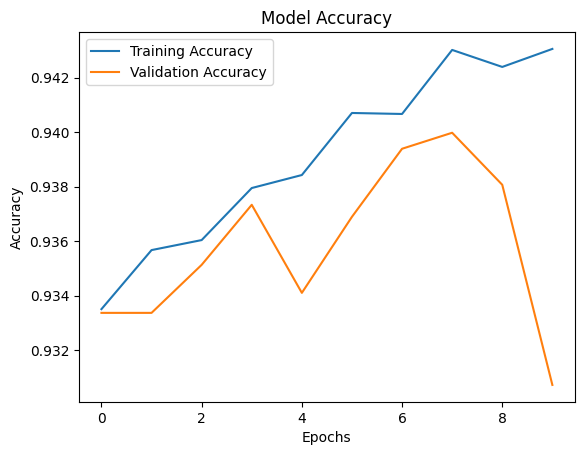

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()
